# Proyecto

Objetivo: Analizar la seguridad de contraseñas con base en la lista de contraseñas y su frecuencia de uso

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy import random
from torch.multiprocessing import Process, Queue, Lock
import multiprocessing as mp
import random


In [58]:
data =pd.read_csv('passwords/pass (1).csv')
for i in range(2,100):
    filename = pd.read_csv('passwords/pass ('+str(i)+').csv')
    data = pd.concat([data,filename],axis=0)
data

,password,hash,count
0,1980290,083040BB6B1D95F2B8AC447B50D21DAB38DAFF16,13
1,tornadof,0A7709AD9837766F20156FF016ABF66F8036ABC1,13
2,vova87654,66221A7691CDC27D9D31071A0CFA0712C100C7D7,13
3,XpKvShrO,4CB7086C94AE4D82E519FF8F98D0DA1DA38DBE53,13
4,tvjgtl,9E1FD26A17D2EBE7C9FD4181EF49424C7091D484,13
...,...,...,...
6840,491144,4511C39CDA1EFE76964C79783B52053BA7CD09DD,69
6841,xeyfhm3477362341,E2EC663D721E9F22F5CF39D5AA27A89CE00172D0,69
6842,irontree4,350AA827594B47AF3BCB9256E2388EFB958C4529,69
6843,wh2t3v3r,221C76F1C2AD5883003AF5EB7A495A41580B87C5,69


In [59]:
data.isnull().sum()

password    2
hash        0
count       0
dtype: int64

In [60]:
data = data.dropna(axis=0)
data.isnull().sum()

password    0
hash        0
count       0
dtype: int64

In [61]:
data = data.groupby(data['password']).agg({'count':sum}).reset_index()
print(data.shape)
data.head()

(677566, 2)


,password,count
0,!!!!!,401
1,!!!!!!,2304
2,!!!!!!!,386
3,!12345,312
4,!23456,347


In [62]:
data = data.sort_values(by='count',ascending=False)
data.head()

,password,count
43879,123456789,7016669
506981,qwerty,3599486
35227,111111,2900049
43856,12345678,2680521
223879,abc123,2670319


Ahora vamos a establecer una métrica para pasar de la cuenta de las contraseñas a una métrica de su seguridad, para esto se decide hacer un escalamiento estándar al inverso de la cuenta de contraseñas. Esto para darle una mayor scoring a aquellos que tienen menos apariciones.

In [63]:
pass_count = data.iloc[:,1].values
pass_count

array([7016669, 3599486, 2900049, ...,      12,      12,      12])

In [64]:
from copy import copy
passes = copy(data.iloc[:,0].values.tolist())
passes[:5]

['123456789', 'qwerty', '111111', '12345678', 'abc123']

In [65]:
data = None  #Liberamos memoria

Dividimos el conjunto de la seguridad de las contraseñas uniformemente en `n` intervalos

In [78]:
n = 10


intervalo = pass_count.shape[0]//n

pass_security = np.zeros(len(passes))
intervalo_idx = 0
for i in range(n):
    for j in range(intervalo_idx,intervalo_idx+intervalo):
        pass_security[j] = i
        intervalo_idx += 1

for j in range(intervalo_idx,len(pass_count)):
    pass_security[j] = n
    
pass_security = pass_security.astype(int)   
pass_security

array([ 0,  0,  0, ..., 10, 10, 10])

A continuación, hacemos una identificación de cada carácter que aparece en las contraseñas, esto para después poder identificar cada contraseña como una codificación de los carácteres que la componen

In [66]:
dict_letras = {}

idx = 0
for i in range(len(passes)):
    #passes[i] = list(passes[i])
    for letter in passes[i]:
        if letter not in dict_letras.keys():
            dict_letras[letter] = idx
            idx += 1

In [67]:
dict_letras.items()

dict_items([('1', 0), ('2', 1), ('3', 2), ('4', 3), ('5', 4), ('6', 5), ('7', 6), ('8', 7), ('9', 8), ('q', 9), ('w', 10), ('e', 11), ('r', 12), ('t', 13), ('y', 14), ('a', 15), ('b', 16), ('c', 17), ('0', 18), ('i', 19), ('l', 20), ('o', 21), ('v', 22), ('u', 23), ('p', 24), ('m', 25), ('n', 26), ('k', 27), ('d', 28), ('g', 29), ('z', 30), ('s', 31), ('x', 32), ('f', 33), ('h', 34), ('j', 35), ('S', 36), ('V', 37), ('Q', 38), ('B', 39), ('L', 40), ('P', 41), ('J', 42), ('E', 43), ('!', 44), ('A', 45), ('W', 46), ('O', 47), ('R', 48), ('D', 49), ('G', 50), ('.', 51), ('@', 52), ('Y', 53), ('I', 54), ('?', 55), ('T', 56), ('U', 57), ('*', 58), ('M', 59), ('C', 60), ('-', 61), ('F', 62), ('H', 63), ('Z', 64), ('$', 65), ('#', 66), ('X', 67), ('N', 68), ('K', 69), (';', 70), ('%', 71), ('^', 72), ('_', 73), ('&', 74), ("'", 75), ('+', 76), ('~', 77), ('|', 78), ('{', 79), ('}', 80), ('`', 81)])

In [68]:
import torch

A continuación definimos algunas funciones auxiliares para las neuronas de **entrada**:

In [70]:
dict_size = len(dict_letras.values())

def char_to_int(char):
    '''
    Función que convierte una letra a entero
    ------------------------------------
    :param char str:Carácter a codificar
    
    :returns int: Codificación del carácter a su codificación
                correspondiente según el diccionario.
    '''
    for letra, numero in dict_letras.items():
        if letra==char:
            
            return numero


def int_to_char(num):
    '''
    Función que convierte de entero a letra
    ------------------------------------
    :param num int:Entero a decodificar
    
    :returns str: Decodificación del número a su
                correspondiente carácter según el diccionario.
    '''    
    for letra, numero in dict_letras.items():
        if num==numero:
            return letra

def int_to_ohe(num):
    '''
    Función que convierte entero a su representación
    OHE
    --------------------------------------
    :param num int: Entero de codificación a convertir a OHE
    
    :returns tensor: Tensor que contiene el número
                en su representación OHE según el diccionario.
    '''
    ohe = torch.zeros(1,dict_size)
    ohe[0][num] = 1
    
    return ohe



def char_to_ohe(char):
    '''
    Función que convierte una letra a su representación
    OHE
    -----------------------------------------
    :param char str: Carácter a convertir en su 
                        representación OHE.
    :returns tensor: Tensor que contiene el carácter
            en su representación OHE según el diccionario.
    '''
    return int_to_ohe(char_to_int(char))

def passw_tensor(passw):
    '''
    Función que convierte una contraseña a su representación
    OHE
    -----------------------------------------
    :param passw str: Contraseña a convertir en su 
                        representación OHE.
    :returns tensor: Tensor que contiene la contraseña
            en su representación OHE según el diccionario.
    '''
    tensor = torch.zeros(len(passw),1, dict_size)
    
    for i, letra in enumerate(passw):
        tensor[i][0][char_to_int(letra)] = 1
    return tensor

passw_tensor('abc')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    

Ahora definiremos algunas funciones auxiliares para las neuronas de **salida**:

In [ ]:

def int_ohe(numero):
    '''
    Función que dado un número de seguridad, devuelve el tensor ohe
    '''
    tensor = torch.zeros(1,n+1)
    tensor[0][numero] = 1
    return tensor

Una vez definidas estas funciones, la siguiente función nos permitirá obtener una muestra aleatoria de las contraseñas con su respectiva seguridad:

In [77]:
def random_training_example(contrasenas, etiquetas):
    '''
    Función que dada una lista de contraseñas y sus etiquetas, regresa
    una muestra aleatoria con su etiqueta correspondiente (seguridad)
    ----------------------------------------------------------
    :param contrasenas [str]: Lista de contraseñas
    :param etiquetas [int]: Lista de la seguridad de las contraseñas
    
    :returns password str: Contraseña
    :returns etiqueta int: Seguridad de la contraseña
    :returns password_tensor tensor: Codificación OHE de la contraseña
    :returns etiqueta_tensor tensor: Codificación OHE de la seguridad
    '''
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return random_idx
    
    idx = random_choice(contrasenas)
    password = contrasenas[idx]
    etiqueta = etiquetas[idx]
    
    password_tensor = passw_tensor(password)
    etiqueta_tensor = int_ohe(etiqueta)

    return password, etiqueta, password_tensor, etiqueta_tensor

random_training_example(passes,pass_security)

('randyd',
 4,
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [20]:
def train_test_split(dataset,labels,test_size=0.2,seed=10):
    '''
    Función que divide los conjuntos en entrenamiento y validación.
    -------------------------------------------
    :param dataset [str]: Conjunto el cual de entrada
    :param labels [int]: Conjunto de etiquetas correcta
    :param test_size float: Tamaño del conjunto de validación (default=0.2)
    :param seed int: Semilla para la generación aleatoria de los 
                    conjuntos (default=10)
    
    :returns X_train [str]: Conjunto de entrenamiento de entrada.
    :returns X_test [str]: Conjunto de validación de entrada.
    :returns y_train [int]: Conjunto de entrenamiento de salida.
    :returns y_test [int]: Conjunto de validación de salida.
    '''
    rn = np.random.RandomState(seed)
    m = int(len(dataset)*(1-test_size))
    
    choice = rn.choice(len(dataset),m,replace=False)
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for i in choice:
        X_train.append(dataset[i])
        y_train.append(labels[i])
    for i in range(len(dataset)):
            if i not in choice:
                X_test.append(dataset[i])
                y_test.append(labels[i])
    return X_train, X_test, y_train, y_test
print(len(passes))

X_train, X_test, y_train, y_test = train_test_split(passes,pass_security)

677566


La primera arquitectura a usar en la red recurrente es la siguiente:

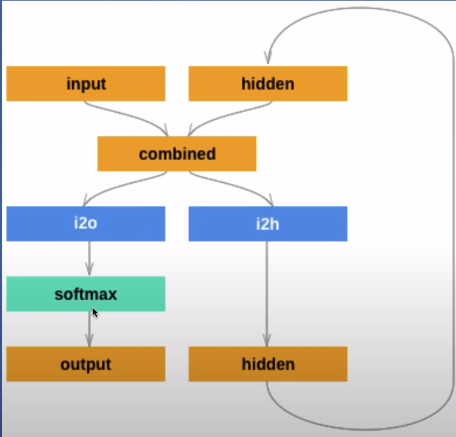

In [103]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class RNN1(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        '''
        Parámetros de inicialización
        ---------------------------------
        :param input_size int: Tamaño de entrada
        :param hidden_size int: Número de neuronas en las capas ocultas
        :param output_size int: Neuronas en las capas de salida
        '''
        
        super(RNN1, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1) #Input por ejemplo 1,57
    
    def forward(self, input_tensor, hidden_tensor):
        '''
        Realiza feed-forward con las neuronas de entrada y el tensor
        resultante de la iteración anterior
        ------------------------------------------
        :param input_tensor tensor: Tensor de neuronas de entrada
        :param hidden_tensor tensor: Tensor de 'memoria asociativa'
                                de la entrada anterior
        
        :returns output tensor: Tensor de salida
        :returns hidden tensor: Tensor para la entrada siguiente
        '''
        combined = torch.cat((input_tensor, hidden_tensor),1 )
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        
        return output, hidden
    
    def init_hidden(self):
        '''
        Primer vector oculto
        -------------------
        :returns tensor: Tensor para la primera neurona de entrada
                        lleno de puros ceros
        '''
        return torch.zeros(1,self.hidden_size)

Ahora definimos algunas funciones para la compatibilidad de contraseñas en cadena de texto y la red:

In [107]:
n_hidden = 128
prueba = RNN1(dict_size, n_hidden, n+1)

In [108]:
def security_from_output(output):
    '''
    Función de softmax al final de una red neuronal. 
    Predice la seguridad de una contraseña dado un tensor output
    -------------------------------------------
    :param output tensor: Tensor del que se calcula el argumento máximo
    
    :returns int: Neurona de salida activada
    '''
    category_idx = torch.argmax(output).item()
    return category_idx

def evaluate_password(password,model):
    '''
    Función que dado una contraseña y una red neuronal,
    evalúa la seguridad de la contraseña según la red.
    -----------------------------------------
    :param password str: Contraseña a evaluar
    :param model RNN: Red que evaluará la contraseña.
    
    :returns int: Seguridad de la contraseña según el modelo.
    '''
    pass_ohe = passw_tensor(password)
    hidden = model.init_hidden()
    for i in range(pass_ohe.size()[0]):
        output, hidden = model(pass_ohe[i], hidden)
    return security_from_output(output)
    
#print(passw_tensor(X_train[0]))
print('La contraseña %s tiene seguridad:' %X_train[0])
evaluate_password(X_train[0],prueba)

La contraseña 123563 tiene seguridad:


10

Las funciones de entrenamiento:

In [120]:
def train1(model, line_tensor, category_tensor, criterion, learning_rate,optimizer):
    '''
    Realiza un paso de entrenamiento con un ejemplar y su etiqueta correcta.
    -------------------------------------------------------------
    :model rnn_net: Modelo a entrenar
    :param passw tensor: Contraseña que entrará a la red en OHE
    :param category_tensor tensor: Etiqueta correcta
    
    :returns output tensor: Tensor de predicción
    :returns loss float: Pérdida del modelo después del entrenamiento
    '''
    hidden = model.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)
    #print(output)
    loss = criterion(output,category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

In [121]:
def train_iterations1(model,passes, pass_security, optimizer,learning_rate=0.01, 
                     criterion=nn.MSELoss(), n_iters=100000,
                     plot_steps=1000, print_steps=5000):
    current_loss = 0
    all_losses = []

    for i in range(n_iters):
        password, etiqueta, password_tensor, etiqueta_tensor = random_training_example(
                                                                passes,pass_security)
        password_tensor = password_tensor.to(device)
        etiqueta_tensor = etiqueta_tensor.to(device)
        output, loss = train(model,password_tensor, etiqueta_tensor,criterion,
                            learning_rate,optimizer)
        current_loss += loss

        if (i+1)%plot_steps == 0:
            all_losses.append(current_loss / plot_steps)
            current_loss = 0
            
        if (i+1)%print_steps == 0:
            guess = security_from_output(output)
            correct = "CORRECTO" if guess == etiqueta else f"EQUIVOCADO ({etiqueta})"
            print(f'''Iter:{i} {i/n_iters *100:.2f}% Perdida:{loss:.4f} 
            Contrasena:{password} / {guess} {correct}''')
            
    plt.figure()
    plt.plot(all_losses)
    plt.show()

In [122]:
n_hidden = 64*1

pass_net1 = RNN1(dict_size, n_hidden, n+1)

print('CUDA:',torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pass_net1 = pass_net1.to(device)

CUDA: False


In [126]:
try:
    std_dict = torch.load('./red_neruonal_recurrente1.pth', map_location=device)
    pass_net1.load_state_dict(std_dict)
    print("Modelo cargado.")
except Exception as e:
    print(e)
    print("Modelo nuevo.")

[Errno 2] No such file or directory: './red_neruonal_recurrente1.pth'
Modelo nuevo.


Iter:19999 2.00% Perdida:6.2815 
            Contrasena:791017 / 1 CORRECTO
Iter:39999 4.00% Perdida:6.2920 
            Contrasena:Jimbob / 0 EQUIVOCADO (1)
Iter:59999 6.00% Perdida:6.2880 
            Contrasena:nokiadermo / 8 EQUIVOCADO (4)
Iter:79999 8.00% Perdida:6.3403 
            Contrasena:ketek1 / 0 EQUIVOCADO (7)
Iter:99999 10.00% Perdida:6.2902 
            Contrasena:maryska / 9 EQUIVOCADO (2)
Iter:119999 12.00% Perdida:6.2782 
            Contrasena:hasee / 5 CORRECTO
Iter:139999 14.00% Perdida:6.3095 
            Contrasena:jeckyll / 0 EQUIVOCADO (6)
Iter:159999 16.00% Perdida:6.3090 
            Contrasena:afepbz / 0 EQUIVOCADO (7)
Iter:179999 18.00% Perdida:6.2998 
            Contrasena:maplewood / 8 EQUIVOCADO (1)
Iter:199999 20.00% Perdida:6.3229 
            Contrasena:Rikki / 0 EQUIVOCADO (6)
Iter:219999 22.00% Perdida:6.3085 
            Contrasena:villano / 4 EQUIVOCADO (2)
Iter:239999 24.00% Perdida:6.2944 
            Contrasena:kamerin1 / 0 EQUIVOCADO (4)
Ite

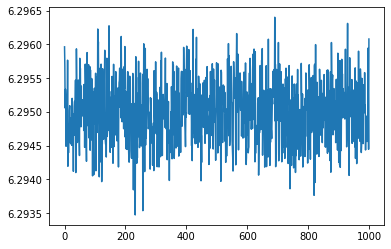

Modelo Guardado


In [131]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(pass_net1.parameters(), lr=0.1)
#n_iters = len(X_train)
n_iters = 1000000
print_steps = int(n_iters/50)
learning_rate = 0.1

train_iterations1(pass_net1,X_train,np.array(y_train),optimizer,learning_rate, 
                 n_iters=n_iters, print_steps=print_steps)

torch.save(pass_net1.state_dict(),"./red_neruonal_recurrente1.pth")
print("Modelo Guardado")

In [134]:
predicciones = []
for passw in X_test:
    prediccion = evaluate_password(passw,pass_net1)
    predicciones.append(prediccion)

In [136]:
from sklearn.metrics import accuracy_score

print('La exactitud del modelo es:',accuracy_score(y_test,predicciones))

La exactitud del modelo es: 0.09610077187596854


Ahora probemos con una segunda red neuronal recurrente con distinta arquitectura. Ahora, tendrá dos capas ocultas antes de pasar al siguiente estaso en lugar de una.

In [138]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class RNN2(nn.Module):
    
    def __init__(self, input_size,layer1_size ,hidden_size, output_size):
        '''
        Parámetros de inicialización
        ---------------------------------
        :param input_size int: Tamaño de entrada
        :param hidden_size int: Número de neuronas en las capas ocultas
        :param output_size int: Neuronas en las capas de salida
        '''
        
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(input_size + hidden_size, layer1_size)
        self.i2h = nn.Linear(layer1_size, hidden_size)
        self.i2o = nn.Linear(layer1_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1) #Input por ejemplo 1,57
    
    def forward(self, input_tensor, hidden_tensor):
        '''
        Realiza feed-forward con las neuronas de entrada y el tensor
        resultante de la iteración anterior
        ------------------------------------------
        :param input_tensor tensor: Tensor de neuronas de entrada
        :param hidden_tensor tensor: Tensor de 'memoria asociativa'
                                de la entrada anterior
        
        :returns output tensor: Tensor de salida
        :returns hidden tensor: Tensor para la entrada siguiente
        '''
        
        combined = torch.cat((input_tensor, hidden_tensor),1 )
        #print(combined)
        layer1 = torch.sigmoid(self.fc1(combined))
        hidden = self.i2h(layer1)
        output = self.i2o(layer1)
        output = self.softmax(output)
        
        return output, hidden
    
    def init_hidden(self):
        '''
        Primer vector oculto
        -------------------
        :returns tensor: Tensor para la primera neurona de entrada
                        lleno de puros ceros
        '''
        return torch.zeros(1,self.hidden_size)

Adicionalmente, cada iteración será un entrenamiento de todo el conjunto de entrenamiento con separación de mini-batches entre cada paso de descenso por el gradiente.

In [35]:
def train_iterations(model,passes, pass_security, optimizer, learning_rate=0.01, 
                     criterion=nn.MSELoss(), n_iters=1000, batch_size=5000):
    current_loss = 0
    all_losses = []

    for i in range(n_iters):
        
        optimizer.zero_grad()
        
        for batch_iter in range(batch_size):
            password, etiqueta, password_tensor, etiqueta_tensor = random_training_example(
                                                                    passes,pass_security)
            output, loss = train(model,password_tensor, etiqueta_tensor,criterion,
                                learning_rate, optimizer)
            current_loss += loss

        optimizer.step()
        
        if (i+1)%5 == 0:
            print(i,':', current_loss)
            all_losses.append(current_loss / batch_size)
            current_loss = 0
            
        #if (i+1)%n_iters/50 == 0:
        #    guess = security_from_output(output)
        #    correct = "CORRECTO" if guess == etiqueta else f"EQUIVOCADO ({etiqueta})"
        #    print(f'''Iter:{i} {i/n_iters *100:.2f}% Perdida:{loss:.4f} 
        #    Contrasena:{password} / {guess} {correct}''')
            
    plt.figure()
    plt.plot(all_losses)
    plt.show()

In [36]:

def train(model, line_tensor, category_tensor, criterion, learning_rate, optimizer):
    '''
    Realiza un paso de entrenamiento con un ejemplar y su etiqueta correcta.
    -------------------------------------------------------------
    :model rnn_net: Modelo a entrenar
    :param passw tensor: Contraseña que entrará a la red en OHE
    :param category_tensor tensor: Etiqueta correcta
    
    :returns output tensor: Tensor de predicción
    :returns loss float: Pérdida del modelo después del entrenamiento
    '''
    #print(line_tensor)
    hidden = model.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output,category_tensor)
    loss.backward()
    
    
    return output, loss.item()

In [37]:
pass_net2 = RNN(dict_size,32,128,n+1)

In [ ]:
try:
    std_dict = torch.load('./red_neruonal_recurrente2.pth', map_location=device)
    pass_net2.load_state_dict(std_dict)
    print("Modelo cargado.")
except Exception as e:
    print(e)
    print("Modelo nuevo.")

<ipython-input-22-07ec120d4158>:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


4 : 180686.6856226921
9 : 158207.23965454102
14 : 157728.48303318024
19 : 157172.43016767502
24 : 157152.39694595337
29 : 157081.59831762314
34 : 156984.65678453445
39 : 156964.71923971176
44 : 156950.23340463638
49 : 156930.78427124023
54 : 156926.69552230835
59 : 156920.82666444778
64 : 156917.6409239769
69 : 156916.7630391121
74 : 156915.28966665268
79 : 156914.92451143265
84 : 156914.59390878677
89 : 156914.397585392
94 : 156914.25785541534
99 : 156914.1461277008
104 : 156914.04419708252
109 : 156913.9960179329
114 : 156913.95074367523
119 : 156913.99814033508
124 : 156913.89306735992
129 : 156913.9281926155
134 : 156913.91936731339
139 : 156913.87963294983
144 : 156913.9039463997
149 : 156913.89954566956
154 : 156913.94660186768
159 : 156913.8699235916
164 : 156913.9135904312
169 : 156913.88705921173
174 : 156913.88965034485
179 : 156913.96074056625
184 : 156913.952729702
189 : 156913.95811367035
194 : 156913.95165586472
199 : 156913.9396634102
204 : 156913.95790052414
209 : 15691

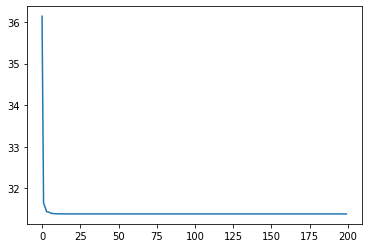

In [38]:
optimizer = torch.optim.Adam(pass_net2.parameters(),lr=0.1)
criterion = nn.NLLLoss()
train_iterations(pass_net2,X_train,y_train,optimizer,n_iters=1000)

torch.save(pass_net2.state_dict(),"./red_neruonal_recurrente2.pth")
print("Modelo Guardado")

In [143]:
predicciones = []
for passw in X_test:
    prediccion = evaluate_password(passw,pass_net2)
    predicciones.append(prediccion)

<ipython-input-22-07ec120d4158>:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


In [144]:
from sklearn.metrics import accuracy_score

print('La exactitud del modelo es:',accuracy_score(y_test,predicciones))

La exactitud del modelo es: 0.10074235872308396


Por lo que se puede ver, aún con una pequeña mejora, el modelo solo predice bien el % de los casos